In [ ]:
# %%

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sim_modules.pupils import AberratedPupil3D
from sim_modules.aperture import Aperture
from sim_modules import plottings
from sim_modules.plottings import (
    AXIAL_FREQ_LABEL,
    HORIZONTAL_COS_LABEL,
    AXIAL_LABEL,
    HORIZONTAL_LABEL,
    VERTICAL_LABEL,
    PSF_AMP_LABEL,
    WAVELENGTH,
    LOCATION_X,
    LOCATION_Y,
    LOCATION_Z,
    LOCATION_XY,
    plot_2Dpupil,
    plot_3Dpupil,
    plot_wavefronterror,
    plot_ctf_xz,
    plot_ctf_amp_xz,
    plot_ctf_phase_xz,
    plot_ctf_yz,
    plot_ctf_amp_yz,
    plot_ctf_phase_yz,
    plot_ctf_xy,
    plot_ctf_amp_xy,
    plot_ctf_phase_xy
)
plt.rcParams['text.usetex'] = True

In [ ]:
# %%

# Imaging mode
IMG_MODE = 'PSFD'
# IMG_MODE = 'LF'
# IMG_MODE = 'SCFF'

In [ ]:
# %%

# Refractive index of the surrounding medium
nb = 1.0  # Refractive index of air
# nb = 1.34  # Refractive index of tissue

In [ ]:
# %%

# Select simulation mode

# SIM_MODE = 'CTF_zoom'  # Calculate the coherent transfer function with zoom FFT
SIM_MODE = 'CTF'  # Calculate the coherent transfer function

In [ ]:
# %%

# Flag normalization of pupils
NORMALIZE = False

In [ ]:
# %%

# Flag paraxial propagation
PARAXIAL = False  # Simulation with paraxial propagation

In [ ]:
# %%

# Spectral dimension

λ = [0.95, 1.04, 1.15]
# λ = [0.8, 0.85, 0.9]
k_num = len(λ)
k = 2 * np.pi / np.asarray(λ, dtype=np.float32)
kc = k[len(k) // 2]

# in tissue
kb = k * nb
kbc = kc * nb

print("Central wavelength [um]: {}".format(2 * np.pi / kc))

Central wavelength [um]: 1.0399999047610027


In [ ]:
# %%

# Wavefront aberration parameters
# NOTE: The wavefront aberration simulation is now available for the same cut-off NA and
# the shared optical path between the illumination and collection.
#
# If the paths are shared but have different cutoff NAs, scaling of the Zernike expansion would be necessary.
#
# In the case of the different optical path, the wavefront aberration should be defined separately.

ns = [(2, 2), (3, 1), (3, 3), (4, 0)]  # Zernike expansion orders
coeff = [(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), 0.0]  # Zernike expansion coefficients (RMS) [µm]

In [ ]:
# %%

# Size parameters of pupil, NA in air
if IMG_MODE == 'SCFF':
    na_co_ill = 0.0
    na_w_ill = 0.0
else:
    # pupil_ill = AberratedPupil3D('circ', 0.988, ns, coeff)
    pupil_ill = AberratedPupil3D('Gauss', 0.25, ns, coeff, na_w=0.2)

# pupil_col = AberratedPupil3D('circ', 0.479, ns, coeff)
pupil_col = AberratedPupil3D('Gauss', 0.25, ns, coeff, na_w=0.2)

In [ ]:
# %%

# Pupil coordinates
νpx_num = 257
# νpx_num = 501

if np.isscalar(pupil_ill.na_co):
    na_co_ill_max = pupil_ill.na_co
else:
    na_co_ill_max = max(pupil_ill.na_co)

if np.isscalar(pupil_col.na_co):
    na_co_col_max = pupil_col.na_co
else:
    na_co_col_max = max(pupil_col.na_co)

νx_max = (kb.max() / (2 * np.pi)) * max(na_co_ill_max, na_co_col_max)
νpx, νpy = np.meshgrid(
    np.linspace(start=-νx_max, stop=νx_max, num=νpx_num, dtype=np.float32),
    np.linspace(start=-νx_max, stop=νx_max, num=νpx_num, dtype=np.float32),
    indexing='xy'
)

dνx = dνy = νpx[0, 1] - νpx[0, 0]

In [ ]:
# %%

# Spatial frequency coordinates for the illumination pupil
match IMG_MODE:
    case 'PSFD':
        νx_ill = νpx
        νy_ill = νpy
    case 'LF':
        νx_ill = νpx[None, 0]
        νy_ill = np.zeros_like(νx_ill)

In [ ]:
# %%

# Pupil coordinates for the central wavelength
σxc_ill = - 2 * np.pi * νx_ill / kbc
σyc_ill = - 2 * np.pi * νy_ill / kbc
σxc_col = - 2 * np.pi * νpx / kbc
σyc_col = - 2 * np.pi * νpy / kbc

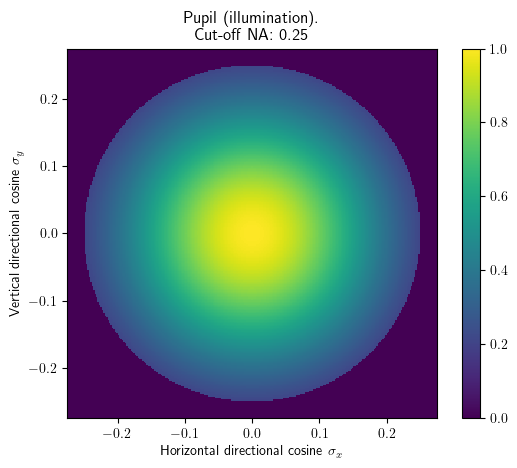

In [ ]:
# %%

# 2D plot of the illumination pupil
match IMG_MODE:
    case 'SCFF':
        pass
    case 'LF':
        P = pupil_ill.pupil2D(σxc_ill, σyc_ill)
        plt.plot(σxc_ill[0], P[0])
        plt.title(
            "Pupil (illumination).\n"
            "Cut-off NA: {}".format(
                pupil_ill.na_co
            )
        )
        plt.xlabel(HORIZONTAL_COS_LABEL)
    case 'PSFD':
        plot_2Dpupil(
            pupil_ill,
            σxc_ill,
            σyc_ill,
            'illumination'
        )

c:\Local\Makita\Dropbox\GitHub\COG-OCTPSF-simulator\sim_modules\plottings.py:551: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


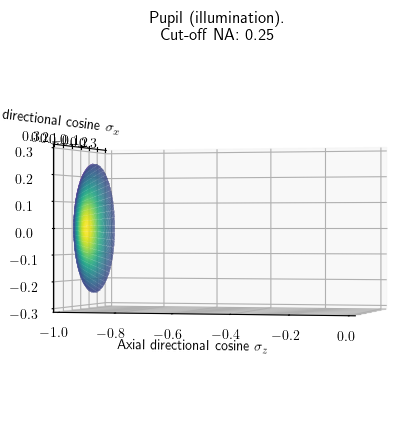

In [ ]:
# %%

# 3D surface plot of the illumination pupil
if IMG_MODE == 'PSFD':
    plot_3Dpupil(
        pupil_ill,
        σxc_ill,
        σyc_ill,
        'illumination'
    )

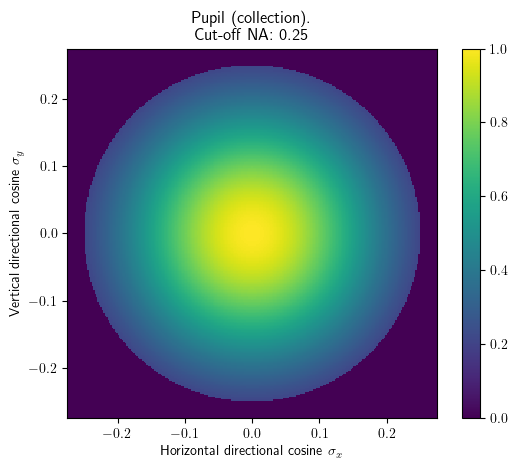

In [ ]:
# %%

# 2D plot of the collection pupil

plot_2Dpupil(
    pupil_col,
    σxc_col,
    σyc_col,
    'collection'
)

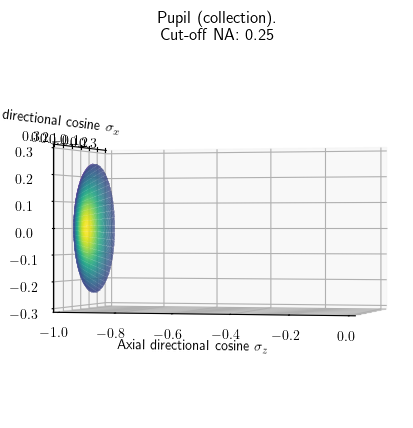

In [ ]:
# %%

# 3D surface plot of the collection pupil
plot_3Dpupil(
    pupil_col,
    σxc_col,
    σyc_col,
    'collection'
)

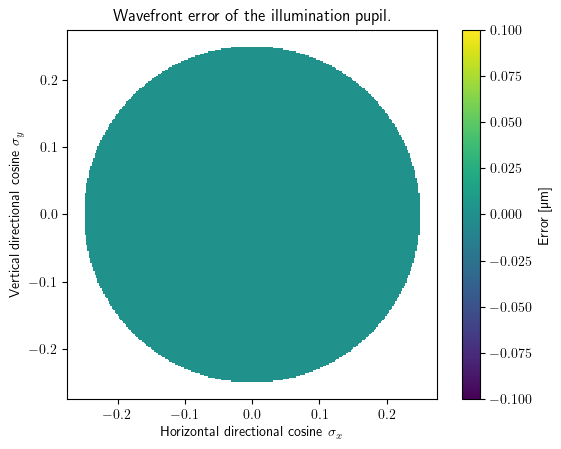

In [ ]:
# %%

# 2D plot of wavefront error in illumination pupil
match IMG_MODE:
    case 'SCFF':
        pass
    case 'LF':
        pupil_ill.set_wavefront_error(σxc_ill, σyc_ill)
        W_ill = pupil_ill.we
        plt.plot(σxc_ill[0], W_ill[0])
        plt.title("Wavefront error of the illumination pupil.")
        plt.xlabel(HORIZONTAL_COS_LABEL)
    case 'PSFD':
        plot_wavefronterror(
            pupil_ill,
            σxc_ill,
            σyc_ill,
            'illumination'
        )

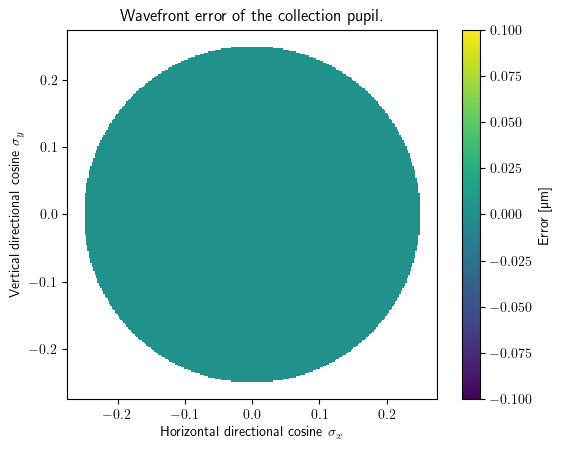

In [ ]:
# %%

# 2D plot of wavefront error in collection pupil
plot_wavefronterror(
    pupil_col,
    σxc_col,
    σyc_col,
    'collection'
)

In [ ]:
# %%

# Spatial coordinate
match IMG_MODE:
    case 'SCFF':
        νx_num = νpx_num
        νy_num = νpx_num
    case 'PSFD':
        νx_num = νpx_num * 2 - 1  # Doubled to take into account convolution
        νy_num = νpx_num * 2 - 1  # Doubled to take into account convolution
    case 'LF':
        νx_num = νpx_num * 2 - 1  # Doubled to take into account convolution
        νy_num = νpx_num
y = sp.fft.fftshift(sp.fft.fftfreq(νy_num, (νpy[1, 0] - νpy[0, 0])))
x = sp.fft.fftshift(sp.fft.fftfreq(νx_num, (νpx[0, 1] - νpx[0, 0])))

print(x.max() - x.min())

485.45370371076797


In [ ]:
# %%

# Spatial frequency cordinate
νx = sp.fft.fftshift(sp.fft.fftfreq(νx_num, 1 / (νx_num * (νpx[0, 1] - νpx[0, 0]))))
νy = sp.fft.fftshift(sp.fft.fftfreq(νy_num, 1 / (νy_num * (νpy[1, 0] - νpy[0, 0]))))

ν_xx, ν_yy = np.meshgrid(
    νx, νy,
    indexing='xy'
)

In [ ]:
# %%

# Rough estimation of the Rayleigh length
if IMG_MODE == 'SCFF':
    z_r = 4 / (na_co_col_max ** 2 * kbc)
else:
    z_r = np.sqrt(
        4 / (na_co_ill_max ** 2 * kbc) *
        4 / (na_co_col_max ** 2 * kbc)
    )

z_r

10.593352042100092

Text(0, 0.5, 'Axial coordinate [um]')

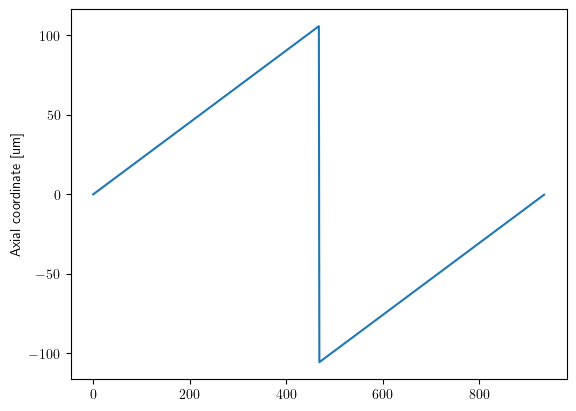

In [ ]:
# %%

# Axial location
zs_r = np.arange(start=0,
                 stop=10.0 * z_r,
                 step=2 * np.pi / (4.2 * kb.max()),
                 dtype=np.float32)
if SIM_MODE.endswith('zoom'):
    # Smooth continuous axial coordinate for zoom FFT.
    z = np.concatenate((-zs_r[-2:0:-1], zs_r))
else:
    # Make the first element as z = 0
    z = np.concatenate((zs_r, -zs_r[-2:0:-1]))
idx_z0 = np.where(z == 0)[0][0]
plt.plot(z)
plt.ylabel("Axial coordinate [um]")

In [ ]:
# %%

# Initialize, allocate memory

h_tilde = np.zeros((νy_num, νx_num) + z.shape + k.shape, dtype=np.complex64)

ill_amp = np.zeros(k.shape, dtype=np.float32)
col_amp = np.zeros(k.shape, dtype=np.float32)

f_zp_ill = np.zeros(z.shape + k.shape, dtype=np.float64)
f_zp_col = np.zeros(z.shape + k.shape, dtype=np.float64)

aperture = Aperture(pupil_ill, pupil_col, IMG_MODE)

h_tilde.nbytes / 1024 ** 2

5637.958923339844

In [ ]:
# %%

for i, kb_i in enumerate(kb):

    h_tilde[..., i] = aperture(
        (νx_ill, νy_ill),
        (νpx, νpy),
        kb_i, z, NORMALIZE, idx_z0=idx_z0, PARAXIAL=PARAXIAL)

    if NORMALIZE:
        ill_amp[i] = aperture.ill_amp
        col_amp[i] = aperture.col_amp

    if SIM_MODE.startswith('CTF'):
        f_zp_ill[..., i] = np.nansum(aperture.ftilde_ill, axis=(0, 1))
        f_zp_col[..., i] = np.nansum(aperture.ftilde_col, axis=(0, 1))

<ipython-input-24-21772653f9a6>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  f_zp_ill[..., i] = np.nansum(aperture.ftilde_ill, axis=(0, 1))
<ipython-input-24-21772653f9a6>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  f_zp_col[..., i] = np.nansum(aperture.ftilde_col, axis=(0, 1))


In [ ]:
# %%

plottings.display_gamma = 1.0

In [ ]:
# %%

# Set the axial frequency coordinate range

νz12 = [
    - 2 * kb.max() / (2 * np.pi),
    - kb.min() / (2 * np.pi) * (
        np.sqrt(1 - na_co_ill_max ** 2) +
        np.sqrt(1 - na_co_col_max ** 2)
    )
]
# νz12 = [-2 * kb.max() / (2 * np.pi), 0]
# νz12 = [kb.min() / (2 * np.pi) * np.sqrt(1 - na_co_ill_max ** 2),
#         # kb.min() / (2 * np.pi) * np.sqrt(1 - na_co_col_max ** 2),
#         kb.max() / (2 * np.pi)]

if SIM_MODE.endswith('zoom'):
    νzm = np.int32(np.round((νz12[1] - νz12[0]) / dνx)) + 1
    νz12[1] = νz12[0] + dνx * (νzm - 1)

In [ ]:
# %%

# coherent transfer function
ki = 1

dz = z[1] - z[0]

if SIM_MODE.endswith('zoom'):

    H = sp.signal.zoom_fft(
        h_tilde[..., ki],
        νz12,
        fs=1/dz,
        m=νzm,
        endpoint=True
    ) * dz
    νz = np.linspace(νz12[0], νz12[1], num=νzm, endpoint=True)
else:
    H = sp.fft.fftshift(sp.fft.fft(h_tilde[..., ki]), axes=-1) * dz
    νz = sp.fft.fftshift(sp.fft.fftfreq(z.size, dz))

print(λ[ki])

1.04


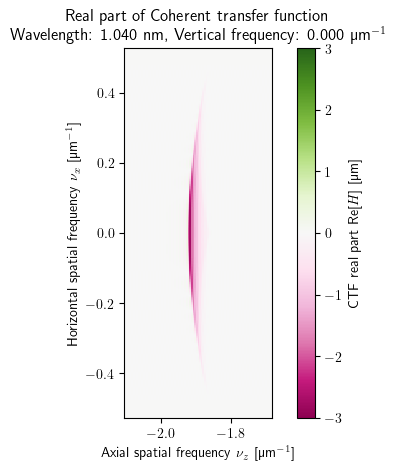

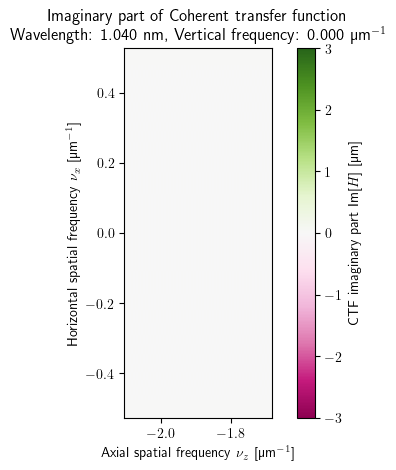

In [ ]:
# %%

if SIM_MODE.endswith('zoom'):
    # Zoom FFT results do not have consistent phase
    plot_ctf_amp_xz(H, νx, νy, νz, νy_num // 2, λ[ki], Hmax=3.0)
else:
    plot_ctf_xz(H, νx, νy, νz, νy_num // 2, λ[ki], νz12, Hmax=3.0)

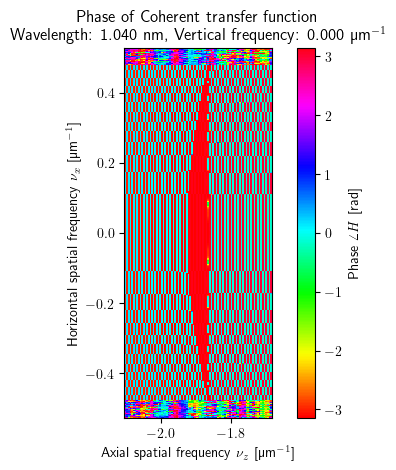

In [ ]:
# %%

if not SIM_MODE.endswith('zoom'):
    plot_ctf_phase_xz(H, νx, νy, νz, νy_num // 2, λ[ki], νz12)

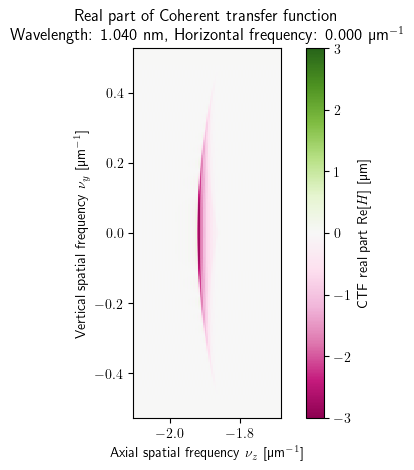

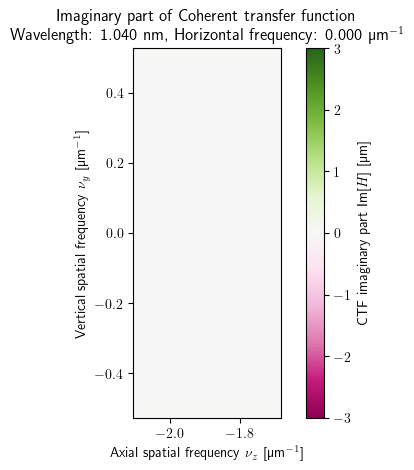

In [ ]:
# %%

if SIM_MODE.endswith('zoom'):
    # Zoom FFT results do not have consistent phase
    plot_ctf_amp_yz(H, νx, νy, νz, νx_num // 2, λ[ki], Hmax=3.0)
else:
    plot_ctf_yz(H, νx, νy, νz, νx_num // 2, λ[ki], νz12, Hmax=3.0)

62

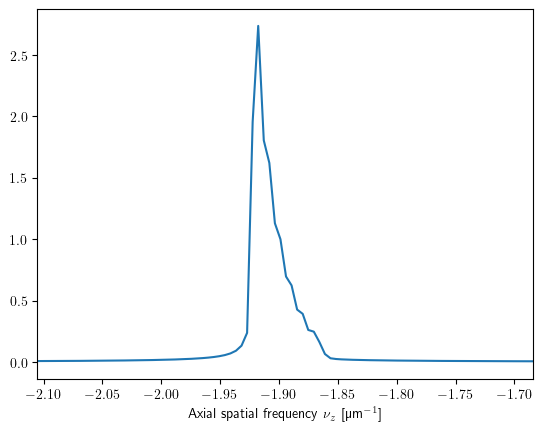

In [ ]:
# %%

plt.plot(νz, np.abs(H[νy_num // 2, νx_num // 2, :]))
plt.xlim(νz12[0], νz12[1])
plt.xlabel(AXIAL_FREQ_LABEL)
np.argmax(np.abs(H[νy_num // 2, νx_num // 2, :]))

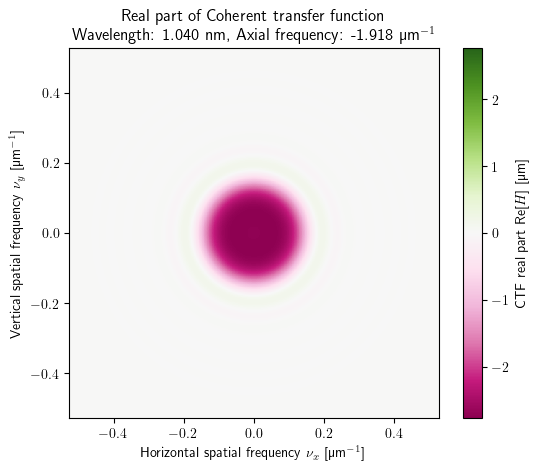

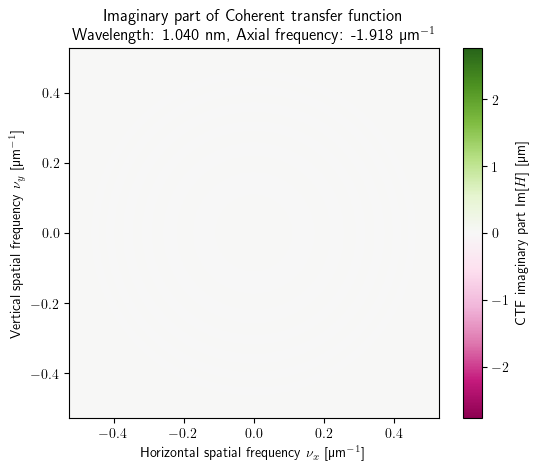

In [ ]:
# %%

idx_νz = 62
if SIM_MODE.endswith('zoom'):
    # Zoom FFT results do not have consistent phase
    plot_ctf_amp_xy(H, νx, νy, νz, idx_νz, λ[ki])
else:
    plot_ctf_xy(H, νx, νy, νz, idx_νz, λ[ki])

In [ ]:
# %%

x12 = [-20.0, 20.0]
xd_num = 129
xd = np.linspace(x12[0], x12[1], num=xd_num, endpoint=True)

ht = sp.signal.zoom_fft(
    sp.signal.zoom_fft(
        h_tilde[..., ki] *
        (kb[ki] ** 2 / (4 * np.pi)),
        x12, fs=1/dνx, m=xd_num, axis=1
    ) * dνx,
    x12, fs=1/dνy, m=xd_num, axis=0
) * dνy

Text(0.5, 1.0, 'Axial profile of PSF\nWavelength: 1.040 nm, ($x_0$, $y_0$) = (0.0 µm, 0.0 µm)')

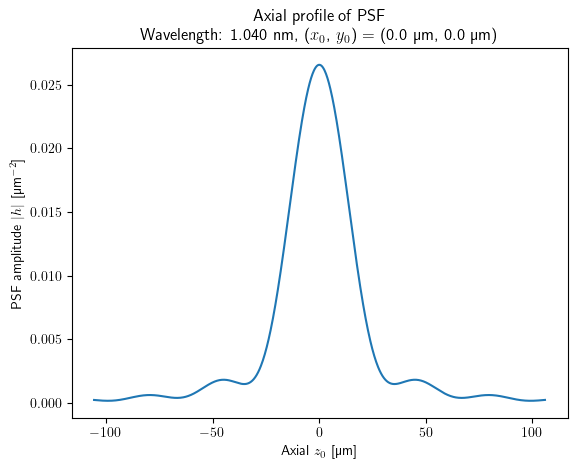

In [ ]:
# %%

plt.plot(
    np.sort(z),
    np.abs(ht[xd_num // 2, xd_num // 2, np.argsort(z)]),
)
plt.xlabel(AXIAL_LABEL)
plt.ylabel(PSF_AMP_LABEL)
plt.title(
    ("Axial profile of PSF\n" +
     WAVELENGTH + ", " + LOCATION_XY).format(
         λ[ki], xd[xd_num // 2], xd[xd_num // 2]))

Text(0.5, 1.0, 'X-slice PSF\nWavelength: 1.040 nm, $y_0$ = 0.0 µm')

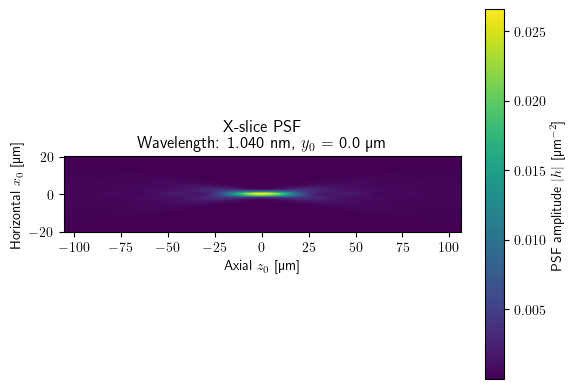

In [ ]:
# %%

plt.pcolormesh(
    np.sort(z), xd,
    np.abs(np.take_along_axis(ht[xd_num // 2], np.argsort(z)[None, :], axis=-1)),
)
plt.colorbar(label=PSF_AMP_LABEL)
plt.gca().set_aspect('equal')
plt.xlabel(AXIAL_LABEL)
plt.ylabel(HORIZONTAL_LABEL)
plt.title(
    ("X-slice PSF\n" +
     WAVELENGTH + ", " + LOCATION_Y).format(λ[ki], xd[xd_num // 2])
)

Text(0.5, 1.0, 'Y-slice PSF\nWavelength: 1.040 nm, $x_0$ = 0.0 µm')

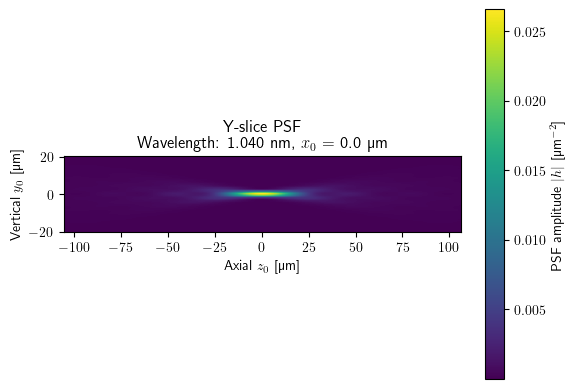

In [ ]:
# %%

plt.pcolormesh(
    np.sort(z), xd,
    np.abs(np.take_along_axis(ht[:, xd_num // 2], np.argsort(z)[None, :], axis=-1)),
)
plt.colorbar(label=PSF_AMP_LABEL)
plt.gca().set_aspect('equal')
plt.xlabel(AXIAL_LABEL)
plt.ylabel(VERTICAL_LABEL)
plt.title(
    ("Y-slice PSF\n" +
     WAVELENGTH + ", " + LOCATION_X).format(λ[ki], xd[xd_num // 2])
)

Text(0.5, 1.0, 'Z-slice PSF\nWavelength: 1.040 nm, $z_0$ = 0.0 µm')

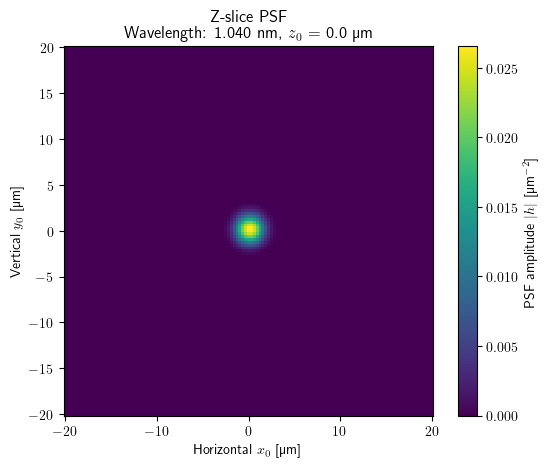

In [ ]:
# %%

# z_i = 0
z_i = idx_z0
plt.pcolormesh(
    xd, xd,
    np.abs(ht[..., z_i]),
)
plt.colorbar(label=PSF_AMP_LABEL)
plt.gca().set_aspect('equal')
plt.xlabel(HORIZONTAL_LABEL)
plt.ylabel(VERTICAL_LABEL)
plt.title(
    ("Z-slice PSF\n" +
     WAVELENGTH + ", " + LOCATION_Z).format(λ[ki], z[z_i])
)